# Measuring the prevalence of frequent flyers

**Author:** Alexei Stepanenko

In this notebook, we  introduce two methods for measuring the prevalence of frequent flyers within a matrix of drug-disease pair treat scores. 

The two methods each yield two scores, one measuring the prevalence of drug frequent-flyers and one measuring the prevalence of disease frequent-flyers. 
For these metrics, higher is better, meaning that a *lower* score indicates a *higher*  prevalence of frequent-flyers. 

1. **Drug-Appearance@n** and **Disease-Appearance@n**: This measures the proportion of drugs/diseases that appear in the top n matrix pairs. 
2. **Drug-Entropy@n** and **Disease-Entropy@n**: This is a refinement of the above metrics which also takes into account how many times each drug/disease appears in the top n. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

from tqdm import tqdm
from scipy.stats import entropy

## Appearance@n 

The appearance@n score is simply the proportion of drugs or diseases that appear in the top n pairs at least once. 

If this score is low, then a large proportion of drugs or diseases will never be reviewed since they do not appear in the top n pairs. 

In [2]:
def give_appearance_at_n(matrix_path_name: str, n_lst: list[int]) -> tuple[list[float], list[float]]:
    """
    Give the drug and disease appearance@n scores for a list of n values.

    Args:
        matrix_path_name: The path to the matrix of drug-disease pair treat scores.
        n_lst: The list of n values to calculate the appearance@n score for.

    Returns:
        A tuple of two lists, the first containing the drug appearance@n scores and the second containing the disease appearance@n scores.
    """
    # Load the matrix
    matrix = pl.read_parquet(matrix_path_name)

    # Total number of unique drugs and diseases
    n_drugs = matrix.select(pl.col("source").n_unique()).to_series().to_list()[0]
    n_diseases = matrix.select(pl.col("target").n_unique()).to_series().to_list()[0]

    # Calculate the number of unique drugs and diseases for each n
    unique_drugs = set()
    unique_diseases = set()
    num_drugs_lst = []
    num_diseases_lst = []

    n_lst = [0] + n_lst
    for i in tqdm(range(len(n_lst) - 1)):
        matrix_slice = matrix.slice(n_lst[i], n_lst[i+1]) 
        unique_drugs = unique_drugs.union(set(matrix_slice.select(pl.col("source")).to_series()))
        unique_diseases = unique_diseases.union(set(matrix_slice.select(pl.col("target")).to_series()))
        num_drugs_lst.append(len(unique_drugs))
        num_diseases_lst.append(len(unique_diseases))

    # Calculate appearance@n for each n
    proportion_drugs_lst = [num/n_drugs for num in num_drugs_lst]
    proportion_diseases_lst = [num/n_diseases for num in num_diseases_lst]

    return proportion_drugs_lst, proportion_diseases_lst

100%|██████████| 1000/1000 [00:05<00:00, 187.70it/s]


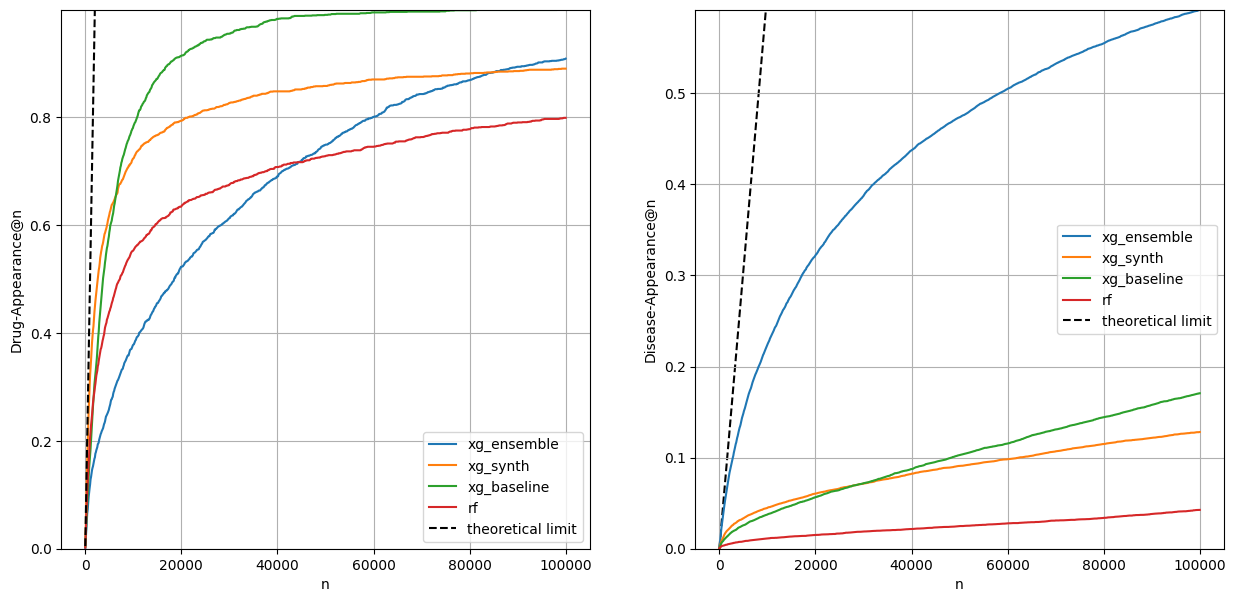

In [3]:
# List of n values
n_max = 100000
n_lst = np.linspace(10,n_max,1000)
n_lst = [int(n) for n in n_lst]

matrix_paths_names = [
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_ensemble/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_ensemble_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_synth/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_synth_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_baseline/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_baseline_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/rf/archive_runs_run-evaluation-redesign-v2_07_model_output_rf_matrix_predictions",
]

model_names = ["xg_ensemble", "xg_synth", "xg_baseline", "rf"]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

max_y_drug  = 0
max_y_disease = 0

# Plot appearance@n curves
for i in range(len(matrix_paths_names)):
    appearance_drugs_lst, appearance_diseases_lst = give_appearance_at_n(matrix_paths_names[i], n_lst)
    ax[0].plot(n_lst, appearance_drugs_lst, label=model_names[i])
    ax[1].plot(n_lst, appearance_diseases_lst, label=model_names[i])
    # Update max y values for y limits
    if max(appearance_drugs_lst) > max_y_drug:
        max_y_drug = max(appearance_drugs_lst)
    if max(appearance_diseases_lst) > max_y_disease:
        max_y_disease = max(appearance_diseases_lst)

# Plot theoretical limits
matrix = pl.read_parquet(matrix_paths_names[0])
n_drugs = matrix.select(pl.col("source").n_unique()).to_series().to_list()[0]
n_diseases = matrix.select(pl.col("target").n_unique()).to_series().to_list()[0]
drug_theoretical_limit_lst = [n/n_drugs for n in n_lst]
disease_theoretical_limit_lst = [n/n_diseases for n in n_lst]
ax[0].plot(n_lst, drug_theoretical_limit_lst, label="theoretical limit", color="black", linestyle="--")
ax[1].plot(n_lst, disease_theoretical_limit_lst, label="theoretical limit", color="black", linestyle="--", zorder=0)

ax[0].set_ylim(0, max_y_drug)
ax[1].set_ylim(0, max_y_disease)
ax[0].set_xlabel("n")
ax[0].set_ylabel("Drug-Appearance@n")
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("n")
ax[1].set_ylabel("Disease-Appearance@n")
ax[1].grid()
ax[1].legend()

plt.show()

## Entropy@n

The above metric may give an overly optimistic view of the prevalence of frequent-flyers.

For example, 90% of drugs appear in the top 1000, by every tenth pair is for the same drug, the appearance@1000 score would be 0.9, but we still have a serious frequent-flyer problem. 

The Entropy@n score addresses this issue by taking into account how many times each drug or disease appears in the top n pairs.


#### Definition 

We define Drug-Entropy@n as follows. Disease-Entropy@n is defined analogously. 

Let $D$ be the set of drugs in the matrix. Let $\text{count}_n(d)$ be the number of times drug $d \in D$ appears in the top $n$ pairs. 

Then the Drug-Entropy@n score is defined at the entropy of the discrete probability distribution 
$$p(d) = \frac{\text{count}_n(d)}{n}.$$ 
To ensure the metric is between 0 and 1, we set the base of the entropy to the number of unique drugs $|D|$. This is written as
$$
\text{Drug-Entropy}\text{@n} = - \sum_{d \in D} p(d) \log_{|D|} p(d).
$$

#### Examples 
1. (worst case) Suppose that 1 drug dominates the entire top 1000 pairs.  Then, $\text{Drug-Entropy}\text{@n} = 0$.
2. (best case) Suppose that we have 1000 drugs that each appear exactly once in the top 1000 pairs.  Then, $\text{Drug-Entropy}\text{@n} = \log_{1000} 1000 = 1$.


In [4]:
def give_entropy_at_n(matrix_path_name: str, n_lst: list[int]) -> tuple[list[float], list[float]]:
    """
    Give the drug and disease entropy@n scores for a list of n values.

    Args:
        matrix_path_name: The path to the matrix of drug-disease pair treat scores.
        n_lst: The list of n values to calculate the entropy@n score for.

    Returns:
        A tuple of two lists, the first containing the drug entropy@n scores and the second containing the disease entropy@n scores.
    """
    # Load the matrix
    matrix = pl.read_parquet(matrix_path_name)

    n_drugs = matrix.select(pl.col("source").n_unique()).to_series().to_list()[0]
    n_diseases = matrix.select(pl.col("target").n_unique()).to_series().to_list()[0]
    drug_entropy_lst = []
    disease_entropy_lst = []

    # Initialize count DataFrames with all unique drugs/diseases
    drug_count = matrix.select('source').unique().with_columns(pl.lit(0).alias('count'))
    disease_count = matrix.select('target').unique().with_columns(pl.lit(0).alias('count'))

    n_lst = [0] + n_lst
    for i in tqdm(range(len(n_lst) - 1)):
        matrix_slice = matrix.slice(n_lst[i], n_lst[i+1] - n_lst[i])

        def update_count(count_df: pl.DataFrame, matrix_slice: pl.DataFrame, col_name: str) -> pl.DataFrame:
            """
            Update the count given new elements in the matrix slice.
            """
            slice_count = matrix_slice.select(pl.col(col_name)).to_series().value_counts(name='count_new')
            
            count_df = (count_df
                .join(slice_count, on=col_name, how='left')
                .with_columns(pl.col('count_new').fill_null(0))
                .with_columns((pl.col('count') + pl.col('count_new')).alias('count'))
                .drop('count_new'))
            
            return count_df

        drug_count = update_count(drug_count, matrix_slice, "source")
        disease_count = update_count(disease_count, matrix_slice, "target")

        drug_entropy_lst.append(entropy(drug_count.select('count').to_numpy().flatten(), base=n_drugs))
        disease_entropy_lst.append(entropy(disease_count.select('count').to_numpy().flatten(), base=n_diseases))

    return drug_entropy_lst, disease_entropy_lst

100%|██████████| 1000/1000 [00:00<00:00, 1087.62it/s]


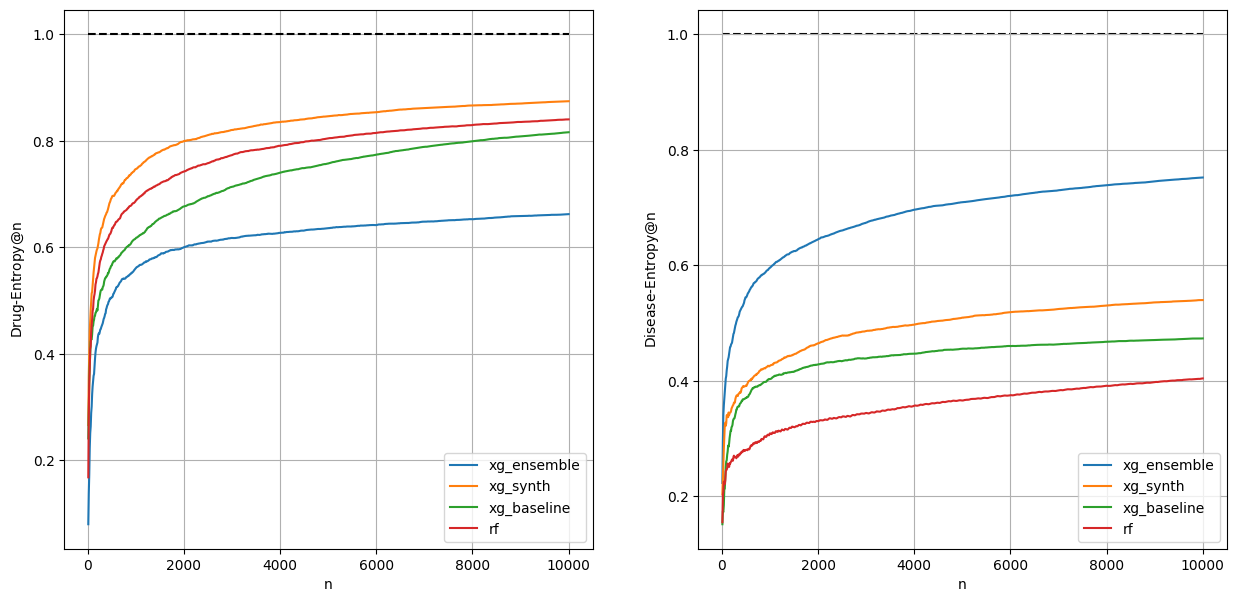

In [5]:
# List of n values
n_max = 10000
n_lst = np.linspace(10,n_max,1000)
n_lst = [int(n) for n in n_lst]

matrix_paths_names = [
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_ensemble/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_ensemble_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_synth/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_synth_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/xg_baseline/archive_runs_run-evaluation-redesign-v2_07_model_output_xg_baseline_matrix_predictions",
    "/Users/alexei/Documents/data/pipeline_output_data/evaluation_redesign_v2/matrices/rf/archive_runs_run-evaluation-redesign-v2_07_model_output_rf_matrix_predictions",
]

model_names = ["xg_ensemble", "xg_synth", "xg_baseline", "rf"]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

max_y_drug  = 0
max_y_disease = 0



# Plot appearance@n curves
for i in range(len(matrix_paths_names)):
    drug_entropy_lst, disease_entropy_lst = give_entropy_at_n(matrix_paths_names[i], n_lst)
    ax[0].plot(n_lst, drug_entropy_lst, label=model_names[i])
    ax[1].plot(n_lst, disease_entropy_lst, label=model_names[i])
    # Update max y values for y limits
    if max(drug_entropy_lst) > max_y_drug:
        max_y_drug = max(drug_entropy_lst)
    if max(disease_entropy_lst) > max_y_disease:
        max_y_disease = max(disease_entropy_lst)

# Plot theoretical limits
ones_lst = [1 for n in n_lst]
ax[0].plot(n_lst, ones_lst, color="black", linestyle="--")
ax[1].plot(n_lst, ones_lst,  color="black", linestyle="--", zorder=0)


ax[0].set_xlabel("n")
ax[0].set_ylabel(r"$\text{Drug-Entropy@n}$")
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("n")
ax[1].set_ylabel(r"$\text{Disease-Entropy@n}$")
ax[1].grid()
ax[1].legend()

plt.show()

### Example

Below, we provide a plot illustrating why the entropy@n metric effectively measures the prevalence of frequent-flyers. 
If there are many frequent flyers, then there are certain entities (drugs or diseases) that appear many times in the top $n$, then the entropy of the count distribution (i.e. $p(d)$ above) will be low compared to the entropy of a random selection of entities.  

In [6]:
n = 5000

matrix = pl.read_parquet(matrix_paths_names[0])
all_drugs = matrix.select(pl.col("source")).unique().with_row_index("index")
sample_drugs = all_drugs.select(pl.col("source")).sample(n, with_replacement=True)
top_drugs = matrix.select(pl.col("source")).head(n)
sample_drugs_count = sample_drugs.group_by(pl.col("source")).len().join(all_drugs, on="source", how="right").fill_null(0)
top_drugs_count = top_drugs.group_by(pl.col("source")).len().join(all_drugs, on="source", how="right").fill_null(0)

max_y = max(max(sample_drugs_count.select(pl.col("len")).to_numpy().flatten()), max(top_drugs_count.select(pl.col("len")).to_numpy().flatten()))

base = len(all_drugs)
entropy_sample = entropy(sample_drugs_count.select(pl.col("len")).to_numpy().flatten(), base=base)
entropy_top = entropy(top_drugs_count.select(pl.col("len")).to_numpy().flatten(), base=base)

zero_set_sample = sample_drugs_count.filter(pl.col("len") == 0).select(pl.col("source")).unique().join(all_drugs, on="source", how="left").select(pl.col("index")).to_series().to_list()
zero_set_top = top_drugs_count.filter(pl.col("len") == 0).select(pl.col("source")).unique().join(all_drugs, on="source", how="left").select(pl.col("index")).to_series().to_list()


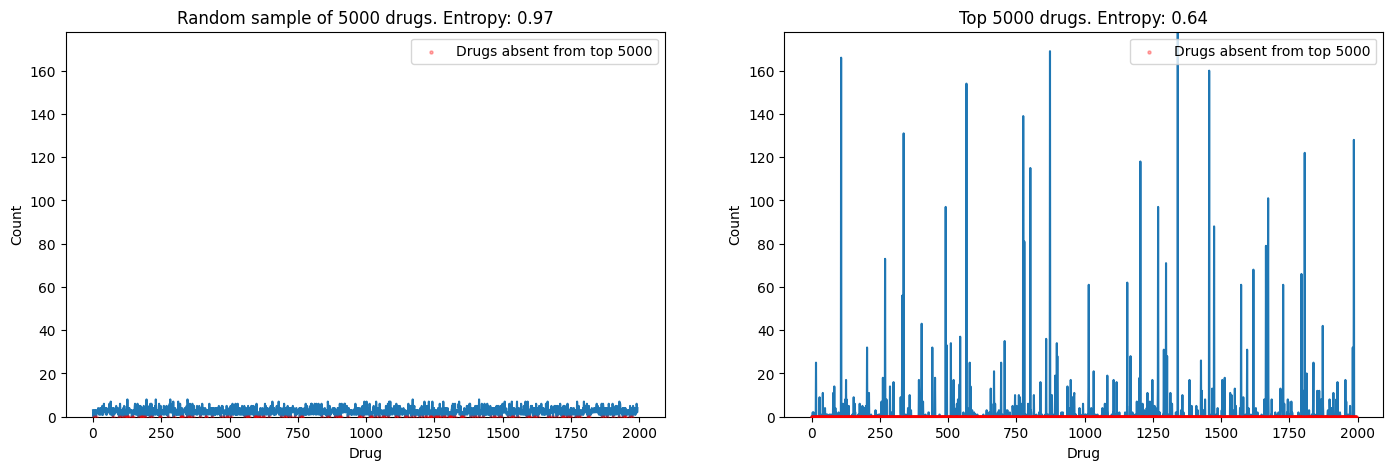

In [7]:
fig, ax = plt.subplots(1,2, figsize = (17,5))

ax[0].plot(sample_drugs_count.select(pl.col("len")).to_numpy().flatten())
ax[1].plot(top_drugs_count.select(pl.col("len")).to_numpy().flatten())
ax[0].scatter(zero_set_sample, np.zeros(len(zero_set_sample)), color="red",  label=f"Drugs absent from top {n}", zorder=10, s=5, alpha=0.3)
ax[1].scatter(zero_set_top, np.zeros(len(zero_set_top)), color="red", label=f"Drugs absent from top {n}", zorder=10, s=5, alpha=0.3)
ax[0].set_xlabel("Drug")
ax[1].set_xlabel("Drug")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y)
ax[0].set_title(f"Random sample of {n} drugs. Entropy: {entropy_sample:.2f}")
ax[1].set_title(f"Top {n} drugs. Entropy: {entropy_top:.2f}")
ax[0].legend()
ax[1].legend()
plt.show()
